In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from problems.time_series.common import trend, seasonality, noise, windowed_dataset, plot_series

tf.__version__

import typing
from tensorflow import keras

if typing.TYPE_CHECKING:
    from keras.api._v2 import keras

In [2]:
time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

2022-02-15 21:43:44.591394: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 21:43:44.594468: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 21:43:44.594584: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-15 21:43:44.595114: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/100
      5/Unknown - 1s 14ms/step - loss: 195.1700 - mae: 195.6700

2022-02-15 21:43:46.332785: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


8/8 [==============================] - 1s 33ms/step - loss: 195.5726 - mae: 196.0726 - lr: 1.0000e-08
Epoch 2/100
8/8 [==============================] - 0s 13ms/step - loss: 194.7819 - mae: 195.2819 - lr: 1.1220e-08
Epoch 3/100
8/8 [==============================] - 0s 14ms/step - loss: 193.5109 - mae: 194.0109 - lr: 1.2589e-08
Epoch 4/100
8/8 [==============================] - 0s 14ms/step - loss: 191.9081 - mae: 192.4081 - lr: 1.4125e-08
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 190.0235 - mae: 190.5235 - lr: 1.5849e-08
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 187.8582 - mae: 188.3582 - lr: 1.7783e-08
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 185.3787 - mae: 185.8787 - lr: 1.9953e-08
Epoch 8/100
8/8 [==============================] - 0s 15ms/step - loss: 182.5483 - mae: 183.0483 - lr: 2.2387e-08
Epoch 9/100
8/8 [==============================] - 0s 15ms/step - loss: 179.3126 - mae: 179.8126 - l

(1e-08, 0.0001, 0.0, 30.0)

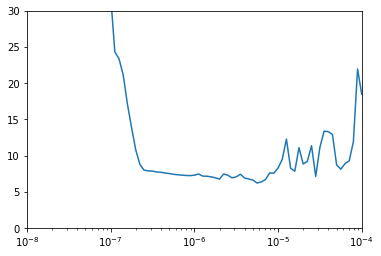

In [3]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    # tf.expand_dims changes the shape by adding 1 to dimensions. For example, a vector with 10 elements could be treated as a 10x1 matrix.
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10 ** (epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [4]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

dataset = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
    tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), input_shape=[None]),
    tf.keras.layers.SimpleRNN(40, return_sequences=True),
    tf.keras.layers.SimpleRNN(40),
    tf.keras.layers.Dense(1),
    tf.keras.layers.Lambda(lambda x: x * 100.0)
])

optimizer = tf.keras.optimizers.SGD(lr=5e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer, metrics=["mae"])
history = model.fit(dataset, epochs=400)

/home/b1102/anaconda3/envs/tensorflow-certification/lib/python3.8/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/400
8/8 [==============================] - 1s 15ms/step - loss: 81.7538 - mae: 82.2537
Epoch 2/400
8/8 [==============================] - 0s 13ms/step - loss: 21.9358 - mae: 22.4302
Epoch 3/400
8/8 [==============================] - 0s 14ms/step - loss: 15.9183 - mae: 16.4127
Epoch 4/400
8/8 [==============================] - 0s 13ms/step - loss: 12.2855 - mae: 12.7790
Epoch 5/400
8/8 [==============================] - 0s 14ms/step - loss: 10.0887 - mae: 10.5783
Epoch 6/400
8/8 [==============================] - 0s 14ms/step - loss: 18.5497 - mae: 19.0459
Epoch 7/400
8/8 [==============================] - 0s 13ms/step - loss: 16.7626 - mae: 17.2542
Epoch 8/400
8/8 [==============================] - 0s 13ms/step - loss: 14.2869 - mae: 14.7794
Epoch 9/400
8/8 [==============================] - 0s 12ms/step - loss: 11.2064 - mae: 11.6979
Epoch 10/400
8/8 [==============================] - 0s 12ms/step - loss: 10.6654 - mae: 11.1577
Epoch 11/400
8/8 [==============================]

6.4405885


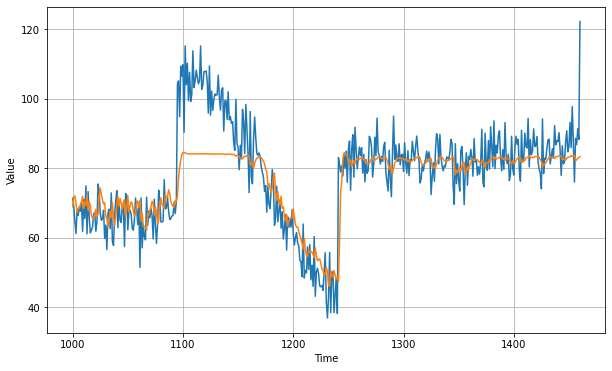

In [5]:
forecast = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time - window_size:]
results = np.array(forecast)[:, 0, 0]

plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

print(tf.keras.metrics.mean_absolute_error(x_valid, results).numpy())

<Figure size 432x288 with 0 Axes>

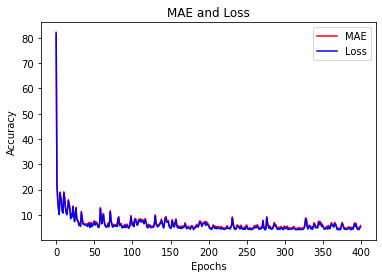

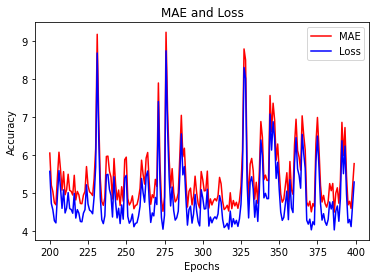

<Figure size 432x288 with 0 Axes>

In [6]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae = history.history['mae']
loss = history.history['loss']

epochs = range(len(loss))  # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()